In [1]:
import lda
import gensim
import numpy as np
import csv
import pandas as pd
import collections 
import scipy.sparse as sp
import nltk
import string
from six import iteritems
from gensim.models.tfidfmodel import TfidfModel
from os import path
import wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline



C:\Anaconda2\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Process
Following function will strip documents of punctuation, tokenize and return a lemmatized list of strings

In [2]:
stopwords=nltk.corpus.stopwords.words('english')
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    
    text1 = text
    text1 = text1.lower()
    text1 = text1.replace("\'s",'')
    text1 = text1.replace("\'",'')
    newString =''
    newtokens = []
   
    exclude = set(string.punctuation)
    for ch in text1:
        if ch in exclude:
            newString = newString+ ' '
        else:
            newString = newString + ch

    tokens = nltk.word_tokenize(newString)
    
    
    for i in tokens:
        try:
             newtokens.append(str(lemmatizer.lemmatize(i)))
        except:
            pass
    return newtokens


## Corpus
Create a class MyCorpus, that reads the input from the documents line by line, thereby not loading the entire document in RAM. We take a subset of the first 500 documents.

In [3]:
class MyCorpus(object):
    def __init__(self, read_file, dictionary):
        self.read_file = read_file
        self.dictionary = dictionary
        
    def __iter__(self):
        #self.dictionary = dictionary
        count = 0
        stoplist =  stopwords
        for line in open(self.read_file):
            count+= 1
            if count == 1: #Exclude header
                continue
            if count == 500:
                break
            split = line.split("\t")
            processed_review = split[2] #Third column contains movie review 
            lem = process(processed_review) #Process the review
            for i in lem:
                if len(i)<3:
                    stoplist.append(i) #Remove words that are less than 3 letters
            no_stopword = list(set(lem) - set(stoplist))
            yield self.dictionary.doc2bow(no_stopword,allow_update = True)
            

The function doc2bow() simply counts the number of occurrences of each distinct word, converts the word to its integer word id and returns the result as a sparse vector. We now create two corpus's for LDA, one is a BoW corpus and the other one is TF-IDF of the 500 movie reviews

Here we assigned a unique integer id to all words appearing in the corpus with the gensim.corpora.dictionary.Dictionary class. This sweeps across the movie reviews, collecting word counts.

In [4]:
dictionary = gensim.corpora.Dictionary()
stoplist =  stopwords
count = 1
with open('labeledTrainData.tsv') as f:
    next(f) #skip header
    for line in f:
        if count == 500:
            break
        count+=1
        z = line.split('\t')
        dictionary.add_documents([process(z[2])])        
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist
            if stopword in dictionary.token2id]
once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
small_words = []
for word in dictionary.token2id:
    if len(word)<3:
        small_words.append(word)

dictionary.filter_tokens(stop_ids + once_ids + small_words)  # remove stop words and words that appear only once
dictionary.compactify()  # remove gaps in id sequence after words that were removed
print(dictionary)

Dictionary(5150 unique tokens: [u'stock', u'secondly', u'shelf', u'similarity', u'personally']...)


Create the two models - LDA with Bag of Words and LDA using TFIDF and plotting the top 10 words for these topics


In [5]:
corpus_memory_friendly = MyCorpus('labeledTrainData.tsv',dictionary)
tfidf = TfidfModel(corpus_memory_friendly) 
corpus_tfidf = tfidf[corpus_memory_friendly]

In [6]:
NUM_TOPICS = 10
lda = gensim.models.LdaModel(corpus_memory_friendly, id2word=dictionary, num_topics=NUM_TOPICS)
lda_tfidf = gensim.models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=NUM_TOPICS)

In [7]:
print "Bag of Words LDA Topics"
bow_terms = []
for i in range(0, NUM_TOPICS):
    temp = lda.show_topic(i, 10)
    terms = []
    bow_terms.append(temp)
    for term in temp:
        terms.append(term)
    print "Top 10 terms for topic #" + str(i)+ ": "+ ", ".join([j[0] for j in terms])

Bag of Words LDA Topics
Top 10 terms for topic #0: movie, film, one, character, like, good, even, get, way, really
Top 10 terms for topic #1: movie, film, like, one, story, character, would, time, good, see
Top 10 terms for topic #2: one, film, movie, time, well, thing, people, get, like, really
Top 10 terms for topic #3: one, film, like, movie, character, would, really, people, good, even
Top 10 terms for topic #4: one, film, movie, even, story, time, character, make, good, would
Top 10 terms for topic #5: film, one, movie, time, even, thing, well, see, like, get
Top 10 terms for topic #6: movie, like, one, film, good, time, get, even, first, thing
Top 10 terms for topic #7: film, good, time, character, one, get, movie, like, also, much
Top 10 terms for topic #8: film, like, one, movie, see, character, much, good, story, would
Top 10 terms for topic #9: film, movie, one, well, make, time, good, way, bad, much


In [8]:
print "TFIDF LDA Topics"
tfidf_terms = []
for i in range(0, NUM_TOPICS):
    temp = lda_tfidf.show_topic(i, 10)
    terms = []
    tfidf_terms.append(temp)
    for term in temp:
        terms.append(term)
    print "Top 10 terms for topic #" + str(i)+ ": "+ ", ".join([j[0] for j in terms])

TFIDF LDA Topics
Top 10 terms for topic #0: read, bad, performance, two, back, get, want, acting, see, story
Top 10 terms for topic #1: definitely, good, saw, end, beginning, understand, favorite, idea, nothing, piece
Top 10 terms for topic #2: many, story, playing, weight, history, would, much, first, actor, interesting
Top 10 terms for topic #3: seen, ever, made, good, best, find, interesting, say, got, time
Top 10 terms for topic #4: even, bad, something, funny, like, comedy, see, plot, funniest, others
Top 10 terms for topic #5: watch, didnt, story, thing, best, really, cast, sitting, see, acting
Top 10 terms for topic #6: great, could, predictable, probably, watchable, worth, better, watching, watched, well
Top 10 terms for topic #7: sure, saw, character, essentially, really, name, job, dont, first, seen
Top 10 terms for topic #8: way, star, superb, well, see, always, role, far, actually, apart
Top 10 terms for topic #9: could, family, going, better, feel, year, acting, doe, bad, 

Since the TFIDF LDA model is giving us more distinct topics and words, we will move forward with visualizations using LDA with a Tf-Idf corpus.

## Visualizations
### Word Clouds - LDA with Tf-Idf Corpus
Plotting word clouds for the first 5 topics


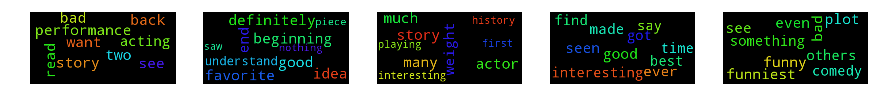

In [9]:
def terms_to_wordcounts(terms, multiplier=10000):
    return  " ".join([" ".join(int(multiplier*i[1]) * [i[0]]) for i in terms])

def plot_images(X,rows,cols):
    f, ax= plt.subplots(rows, cols, figsize=(15, 15))
    count = 0
    img_list = []
    for i in tfidf_terms: 
        wordcloud = WordCloud(max_font_size=40).generate(terms_to_wordcounts(i))
        plt.subplot(1,5,count+1)
        count += 1
        img_list.append(plt.imshow(wordcloud))
        plt.axis('off')
        if count ==5:
            break
    return img_list

plot_images(tfidf_terms,1,5)
plt.show()

### Probabilities of each topic being in the first 5 Documents

We will use the attribute get_document_topics of the LdaModel from gensim. To do so, we need to feed it a docoument for which it will return the topic-document probabilities. We read our file again to take the first 10 documents, pre-process similarly as we did for the corpus and then give the document to our model in the get_document_topics method.

In [10]:
count = 0
doc_topic = []
for line in open('labeledTrainData.tsv'):
    gen_dict = gensim.corpora.Dictionary()
    count+= 1
    if count == 1:
        continue
    if count == 11:
        break
    split = line.split("\t")
    processed_review = split[2]
    lem = process(processed_review)
    for i in lem:
        if len(i)<3:
            stoplist.append(i)
    no_stopword = list(set(lem) - set(stoplist))   
    doc_topic.append(lda_tfidf.get_document_topics(gen_dict.doc2bow(no_stopword,allow_update = True)))


Plotting the probabilities of each topic being in any one of the 5 documents.

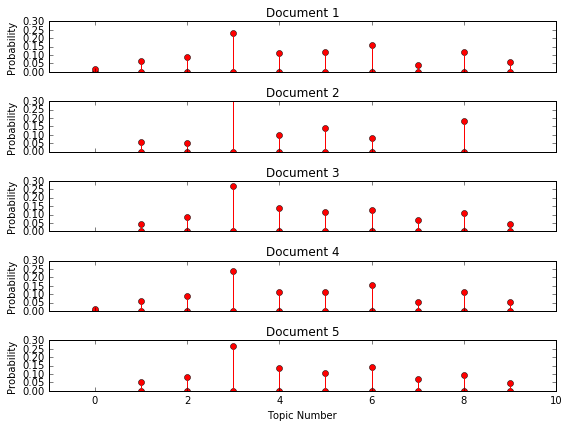

In [11]:
f, ax= plt.subplots(5, 1, figsize=(8, 6), sharex=True)
count = 0
for i in doc_topic:
    for j in i:
        index = j[0]
        prob = j[1]
        ax[count].stem([index,index],[0,prob],linefmt='r-',
               markerfmt='ro', basefmt='w-')
        ax[count].set_xlim(-1, 10)
        ax[count].set_ylim(0, 0.3)
        ax[count].set_ylabel("Probability")
        ax[count].set_title("Document {}".format(count+1))
    count+=1
    if count == 5:
        break
        
ax[4].set_xlabel("Topic Number")

plt.tight_layout()
plt.show()



### Plotting the probabilities of each word occuring in each topic
We take a thousand words of each topic and plot the probabilities of each word occuring for 5 topics. The similar graphs are due to the small sample set and number of topics selected - running LDA with a Tf-Idf on the entire corpus with a large number of topics should lead to different word distributions for each topic

In [12]:
topic_word_prob = []
for i in range(5):
    topic_word_prob.append(lda_tfidf.get_topic_terms(i,topn = 1000))

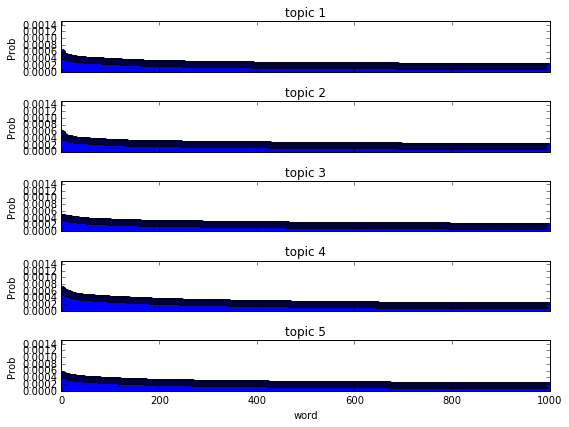

In [13]:
f, ax= plt.subplots(5, 1, figsize=(8, 6), sharex=True)
count = 0
for i in topic_word_prob:
    for k,j in enumerate(i):
        ax[count].stem([k,k],[j[1],j[1]], linefmt='b-',
               markerfmt='bo', basefmt='w-')
        ax[count].set_xlim(-1,1000)
        ax[count].set_ylim(0, 0.0015)
        ax[count].set_ylabel("Prob")
        ax[count].set_title("topic {}".format(count+1))
    count+=1
    if count ==5:
        break


ax[4].set_xlabel("word")
plt.tight_layout()
plt.show()

### PCA Transform of each topic
Plotting a PCA transform on each topic and plot the results in 2-D vector space. 

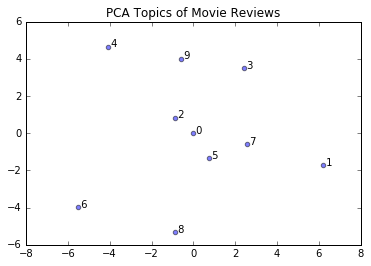

In [14]:
from sklearn.feature_extraction import DictVectorizer
n_topics = NUM_TOPICS

def topics_to_vectorspace(n_topics, n_words=100):
    rows = []
    for i in xrange(n_topics):
        temp = lda_tfidf.show_topic(i, n_words)
        row = dict(((i[1],i[0]) for i in temp))
        rows.append(row)

    return rows    

vec = DictVectorizer()

X = vec.fit_transform(topics_to_vectorspace(n_topics,n_words=100))

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit(X.toarray()).transform(X.toarray())

plt.figure()
for i in xrange(X_pca.shape[0]):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], alpha=.5)
    plt.text(X_pca[i, 0], X_pca[i, 1], s=' ' + str(i))    

plt.title('PCA Topics of Movie Reviews')
plt.show()
plt.close()

### PCA Transform of words
Transform only 1 words from each vector space and topic and find it's PCA

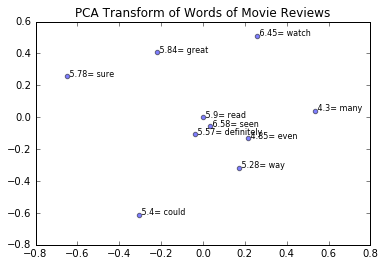

In [25]:
X = vec.fit_transform(topics_to_vectorspace(n_topics,n_words=1))
X_pca = pca.fit(X.T.toarray()).transform(X.T.toarray())

plt.figure()
for i, n in enumerate(vec.get_feature_names()):
    value_word = n.split("=")
    value_word[0] = (float(value_word[0]) * 10000)
    plt.scatter(X_pca[i, 0], X_pca[i, 1], alpha=.5)
    plt.text(X_pca[i, 0], X_pca[i, 1], s=' ' + str(round(value_word[0],2)) + "= "+value_word[1], fontsize=8)

plt.title('PCA Transform of Words of Movie Reviews')
plt.show()
plt.close()

## Hierarchical clustering - 100 words per topic

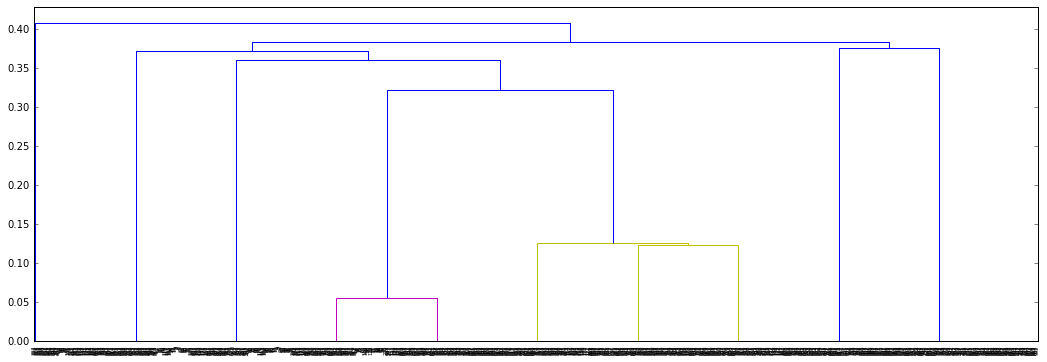

In [22]:
from scipy.cluster.hierarchy import linkage, dendrogram
X = vec.fit_transform(topics_to_vectorspace(n_topics,n_words=100))
X_pca = pca.fit(X.T.toarray()).transform(X.T.toarray())
plt.figure(figsize=(18,6))
R = dendrogram(linkage(X_pca))
plt.savefig("dendro")
plt.show()
plt.close()

## Correlation matrix

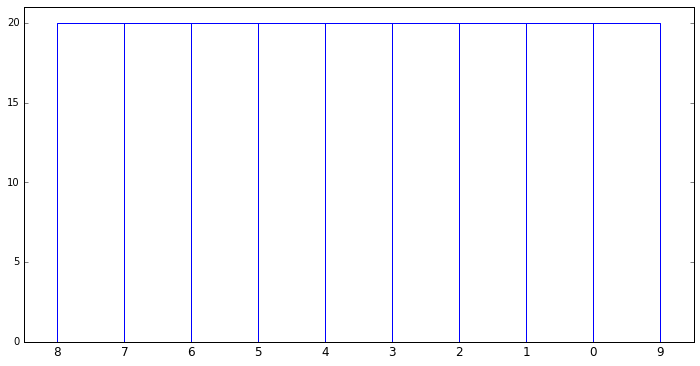

In [23]:

from scipy.spatial.distance import pdist, squareform

cor = squareform(pdist(X.toarray(), metric="euclidean"))

plt.figure(figsize=(12,6))
R = dendrogram(linkage(cor))
plt.savefig("corr")
plt.show()
plt.close()

## Network

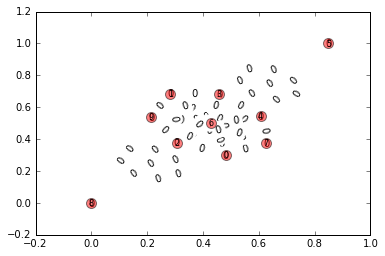

In [24]:
import networkx as nx

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

pca_norm = make_pipeline(PCA(n_components=20), Normalizer(copy=False))

X_pca_norm = pca_norm.fit(X.toarray()).transform(X.toarray())

cor = squareform(pdist(X_pca_norm, metric="euclidean"))

G = nx.Graph()

for i in xrange(cor.shape[0]):
    for j in xrange(cor.shape[1]):
        if i == j:
            G.add_edge(i, j, {"weight":0})
        else:
            G.add_edge(i, j, {"weight":1.0/cor[i,j]})

edges = [(i, j) for i, j, w in G.edges(data=True) if w['weight'] > .8]
edge_weight=dict([((u,v,),int(d['weight'])) for u,v,d in G.edges(data=True)])

#pos = nx.graphviz_layout(G, prog="twopi") # twopi, neato, circo
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=100, alpha=.5)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=1)
nx.draw_networkx_edge_labels(G, pos ,edge_labels=edge_weight)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

plt.show()
plt.close()

## References
https://tedunderwood.com/2012/11/11/visualizing-topic-models/

https://gist.github.com/tokestermw/3588e6fbbb2f03f89798

http://sujitpal.blogspot.com/2014/08/topic-modeling-with-gensim-over-past.html

http://chrisstrelioff.ws/sandbox/2014/11/13/getting_started_with_latent_dirichlet_allocation_in_python.html

